# Approximate Bayesian Compatation Sequential Monte Carlo
(or ABC Population Monte Carlo)

In [1]:
import hypothesis
import matplotlib.pyplot as plt
import torch

As in every Bayesian inference setting we have to define a prior $p(\theta)$, which is in our case $\mathcal{U}(-10, 10)$.

In [48]:
from torch.distributions.uniform import Uniform

lower = torch.tensor([-10]).float()
upper = torch.tensor([10]).float()
prior = Uniform(lower, upper)

The simulation-based or likelihood-free setting also requires the definition of a forward model.

In [49]:
from hypothesis.simulation import Simulator

class NormalSimulator(Simulator):
    
    def __init__(self):
        super(NormalSimulator, self).__init__()
        
    def forward(self, inputs):
        inputs = inputs.view(-1, 1)

        return torch.randn(inputs.size(0), 1) + inputs

simulator = NormalSimulator()

Let's check how the joint $p(\theta,x)$ looks like.

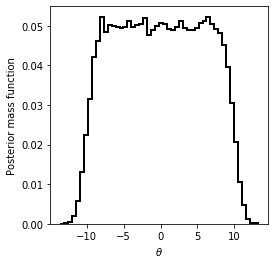

In [50]:
from hypothesis.visualization.util import make_square

n = torch.Size([100000])
inputs = prior.sample(n)
outputs = simulator(inputs)

plt.hist(outputs.numpy(), bins=50, density=True, color="black", histtype="step", lw=2)
plt.xlabel(r"$\theta$")
plt.ylabel("Posterior mass function")
make_square(plt.gca())
plt.show()

Every Bayesian setting requires an observation $x$ (or a set of observations) to compute the posterior of:

In [51]:
truth = prior.sample()
observation = simulator(truth)

print("Observation:", observation.item())

Observation: 0.25136929750442505


In [52]:
from hypothesis.engine import Procedure

import numpy as np

class ApproximateBayesianComputationSequentialMonteCarlo(Procedure):
    r""""""

    def __init__(self, simulator, prior, summary, acceptor, particles=1000):
        super(ApproximateBayesianComputationSequentialMonteCarlo, self).__init__()
        # Main ABC SMC properties.
        self.acceptor = acceptor
        self.prior = prior
        self.simulator = simulator
        self.summary = summary
        self.num_particles = particles
        # Sampler state properties.
        self.particles = []
        self.weights = np.ones(self.num_particles) / self.num_particles
        self.covariance = None
        self._reset()

    def _register_events(self):
        # TODO Implement.
        pass

    def _reset(self):
        self.covariance = None
        self.particles = []
        self.weights = []

    def _sample_from_prior(self, summary_observation):
        for particle_index in range(self.num_particles):
            sample = None
            while sample is None:
                prior_sample = self.prior.sample()
                x = self.simulator(prior_sample)
                s = self.summary(x)
                if self.acceptor(summary_observation, s):
                    sample = prior_sample.unsqueeze(0)
                    self.particles.append(sample)
        self.particles = torch.cat(self.particles, dim=0)
        self.covariance = 2 * torch.from_numpy(np.cov(self.particles.numpy().T)).float()

    def _sample_particle(self):
        indices = np.arange(self.num_particles)
        sampled_index = np.random.choice(self.num_particles, 1, p=self.weights)
        
        return self.particles[sampled_index]
        
    def _resample_particles(self, summary_observation):
        new_particles = self.particles.clone()
        new_particles.zero_()
        for particle_index in range(self.num_particles):
            new_particle = None
            while new_particle is None:
                proposal = self._sample_particles()
                new_particles[particle_index, :] = proposal
                # TODO Add pertubation.
                x = self.simulator(proposal)
                s = self.summary(x)
                if self.acceptor(s, summary_observation):
                    new_particle = proposal
            new_particles[particle_index, :] = proposal
        self.particles = new_particles
        # TODO Compute weights.
        
    def sample(self, observation, num_samples=1):
        samples = []

        # Summarize the observation.
        summary_observation = self.summary(observation)
        # Initialize the particles and set initial weights.
        self._sample_from_prior(summary_observation)
        print(self.covariance)
        samples.extend(self.particles)
        num_samples -= self.num_particles
        while num_samples > 0:
            self._resample_particles(summary_observation)
            num_samples -= self.num_particles
        samples = torch.cat(samples, dim=0)

        return samples


tensor(2.6129)


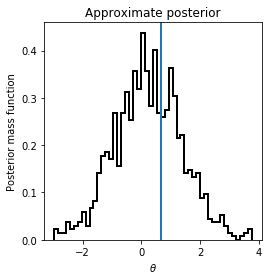

CPU times: user 640 ms, sys: 110 ms, total: 750 ms
Wall time: 530 ms


In [53]:
%%time

#from hypothesis.inference.abc_smc import ApproximateBayesianComputationSequentialMonteCarlo as ABCSMC

def acceptor(a, b, epsilon=1):
    return (a - b).abs().item() < epsilon

def plot_posterior(posterior_samples):
    plt.title("Approximate posterior")
    plt.hist(posterior_samples.numpy(), bins=50, color="black", histtype="step", density=True, lw=2)
    plt.xlabel(r"$\theta$")
    plt.ylabel("Posterior mass function")
    plt.axvline(truth, c="C0", lw=2)
    make_square(plt.gca())
    plt.show()

# Use the identity function as a summary statistic.
def identity(x):
    return x
    
# Allocate the inference procedure.
abc = ApproximateBayesianComputationSequentialMonteCarlo(simulator=simulator,
    prior=prior,
    summary=identity,
    acceptor=acceptor)

# Sample the approximate posterior. We don't want gradients here (but you can).
with torch.no_grad():
    posterior_samples = abc.sample(observation, num_samples=10000)
    
# Plot the approximate posterior.
plot_posterior(posterior_samples)